In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import Image

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train = pd.read_csv('D:\\dataset\\Deeplearninforecast\\train.csv', parse_dates=['date'])

In [3]:
train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [4]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2013-01-01,13
1,1,1,2013-01-02,11
2,1,1,2013-01-03,14
3,1,1,2013-01-04,13
4,1,1,2013-01-05,10


Transform the data into a time series problem

In [5]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We will use the current timestep and the last 29 to forecast 10 days ahead

In [6]:
from PIL import Image
import requests
from io import BytesIO

https://drive.google.com/file/d/1w-delBp9zaLkxyv4yb1IgryexI10JNXn/view?usp=sharing

In [7]:
window = 29
lag = 10
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+10),store(t+10),sales(t+10)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9,1.0,1.0,14.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13,1.0,1.0,11.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11,1.0,1.0,16.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21,1.0,1.0,11.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15,1.0,1.0,14.0


Drop rows with different item or store values than the shifted columns


In [8]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

https://drive.google.com/file/d/1OdA46aEiumk6qqcCMejmPmNnDDuyMwfZ/view?usp=sharing

In [9]:
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+10),store(t+10),sales(t+10)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9,1.0,1.0,14.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13,1.0,1.0,11.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11,1.0,1.0,16.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21,1.0,1.0,11.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912985,50.0,10.0,99.0,50.0,10.0,88.0,50.0,10.0,62.0,50.0,...,72.0,50.0,10.0,52.0,50,10,86,50.0,10.0,63.0
912986,50.0,10.0,88.0,50.0,10.0,62.0,50.0,10.0,81.0,50.0,...,52.0,50.0,10.0,86.0,50,10,53,50.0,10.0,59.0
912987,50.0,10.0,62.0,50.0,10.0,81.0,50.0,10.0,81.0,50.0,...,86.0,50.0,10.0,53.0,50,10,54,50.0,10.0,74.0
912988,50.0,10.0,81.0,50.0,10.0,81.0,50.0,10.0,87.0,50.0,...,53.0,50.0,10.0,54.0,50,10,51,50.0,10.0,62.0


Remove unwanted columns(item & store)

In [10]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

Data split

In [11]:
# Label
labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(series, labels.values, test_size=0.3, random_state=0)
print('Train set shape', X_train.shape)
print('Test set shape', X_test.shape)
X_train.head()

Train set shape (628943, 30)
Test set shape (269547, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
710568,52.0,62.0,47.0,48.0,60.0,32.0,57.0,49.0,48.0,56.0,...,24.0,46.0,46.0,47.0,51.0,50.0,34.0,40.0,38.0,50
222494,93.0,102.0,112.0,114.0,137.0,107.0,86.0,112.0,99.0,119.0,...,89.0,98.0,120.0,109.0,116.0,151.0,134.0,89.0,96.0,116
677599,131.0,73.0,71.0,97.0,106.0,112.0,123.0,123.0,73.0,77.0,...,114.0,104.0,86.0,88.0,91.0,92.0,109.0,113.0,132.0,81
624357,124.0,144.0,132.0,90.0,126.0,108.0,153.0,116.0,117.0,164.0,...,115.0,126.0,126.0,121.0,98.0,96.0,93.0,114.0,126.0,129
681390,78.0,77.0,56.0,69.0,62.0,76.0,62.0,76.0,87.0,40.0,...,71.0,82.0,88.0,66.0,65.0,66.0,58.0,78.0,66.0,76


CNN for Time Series Forecasting
 - For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
 - The convolutional layer should be able to identify patterns between the timesteps.
 - Input shape [samples, timesteps, features].

In [12]:
epochs = 20
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [13]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (628943, 30, 1)
Test set shape (269547, 30, 1)


In [14]:
Y_train.shape

(628943,)

The amount of data is too large, so only part of the data is used.

In [15]:
X_train_tmp = X_train_series[:50000]
X_test_tmp = X_test_series[:10000]
Y_train_tmp = Y_train[:50000]
Y_test_tmp = Y_test[:10000]

In [16]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu',padding = 'same' ,input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
#model_cnn.add(Conv1D(filters=256, kernel_size=5, activation='relu',padding = 'same' ,input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
#model_cnn.add(MaxPooling1D(pool_size=2))
#model_cnn.add(Conv1D(filters=128, kernel_size=4, activation='relu',padding = 'same'))
#model_cnn.add(MaxPooling1D(pool_size=2))
#model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu',padding = 'same' ))
#model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                48050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 48,357
Trainable params: 48,357
Non-trainable params: 0
_________________________________________________________________


In [17]:
#cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_test_series, Y_test), batch_size=batch, shuffle=False, epochs=epochs, verbose=2)
cnn_history = model_cnn.fit(X_train_tmp, Y_train_tmp, validation_data=(X_test_tmp, Y_test_tmp), batch_size=batch, shuffle=False, epochs=epochs, verbose=2)


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 1s - loss: 204.6490 - val_loss: 113.8150
Epoch 2/20
 - 1s - loss: 105.7832 - val_loss: 99.9861
Epoch 3/20
 - 1s - loss: 96.1033 - val_loss: 93.5955
Epoch 4/20
 - 1s - loss: 92.4211 - val_loss: 90.6835
Epoch 5/20
 - 1s - loss: 91.1934 - val_loss: 89.8385
Epoch 6/20
 - 1s - loss: 90.6457 - val_loss: 90.1021
Epoch 7/20
 - 1s - loss: 90.3367 - val_loss: 90.4907
Epoch 8/20
 - 1s - loss: 90.0967 - val_loss: 90.9641
Epoch 9/20
 - 1s - loss: 89.8334 - val_loss: 91.0346
Epoch 10/20
 - 1s - loss: 89.5836 - val_loss: 90.8602
Epoch 11/20
 - 1s - loss: 89.3622 - val_loss: 90.6434
Epoch 12/20
 - 1s - loss: 89.1960 - val_loss: 90.5017
Epoch 13/20
 - 1s - loss: 89.0469 - val_loss: 90.4560
Epoch 14/20
 - 1s - loss: 88.9166 - val_loss: 90.3314
Epoch 15/20
 - 1s - loss: 88.8106 - val_loss: 90.2053
Epoch 16/20
 - 1s - loss: 88.6897 - val_loss: 90.1228
Epoch 17/20
 - 1s - loss: 88.5679 - val_loss: 89.9633
Epoch 18/20
 - 1s - loss: 88.4658 - v

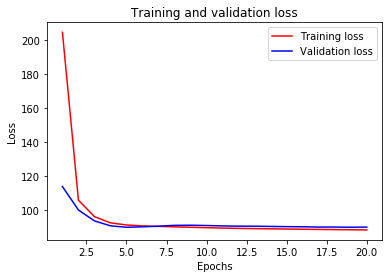

In [18]:
import matplotlib.pyplot as plt

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [19]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_test_pred = model_cnn.predict(X_test_series)
cnn_test_pred_tmp = model_cnn.predict(X_test_tmp)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, cnn_test_pred)))

Train rmse: 9.446026911464651
Test rmse: 9.4801161616253


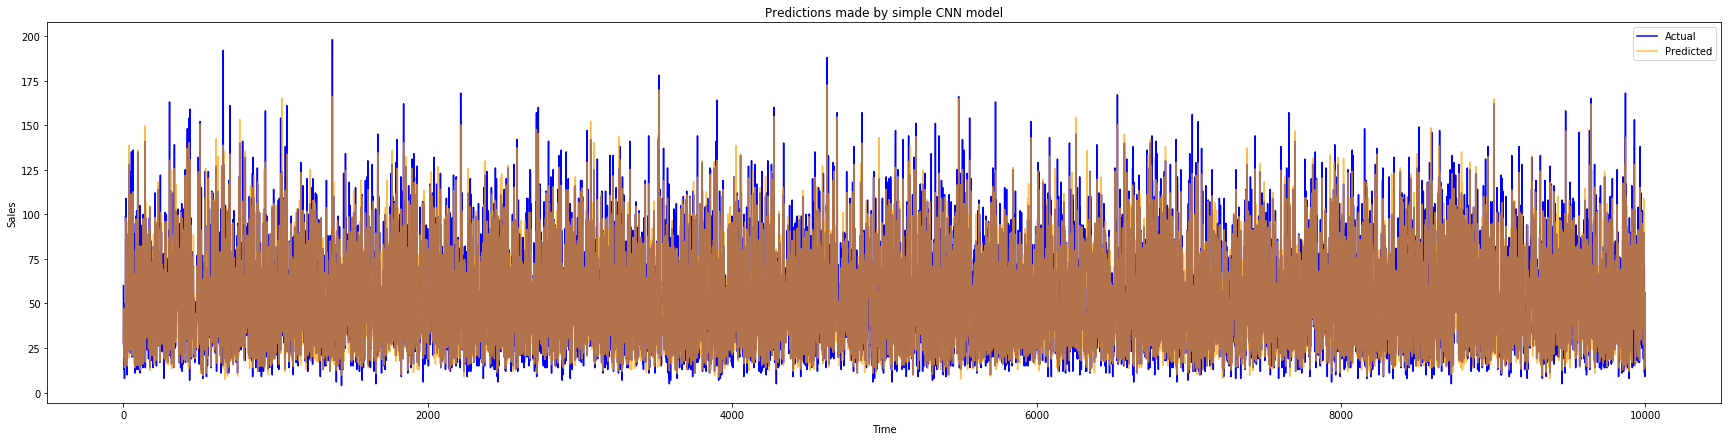

In [20]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(30,7))
    plt.plot(test, color='blue',label='Actual')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    
plot_predictions(Y_test_tmp, cnn_test_pred_tmp, "Predictions made by simple CNN model")

LSTM for Time Series Forecasting
 - Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
 - Input shape [samples, timesteps, features].

In [21]:
model_lstm = Sequential()
model_lstm.add(LSTM(30, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [22]:
#lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_test_series, Y_test), epochs=20, verbose=2)
lstm_history = model_lstm.fit(X_train_tmp, Y_train_tmp, validation_data=(X_test_tmp, Y_test_tmp), epochs=10, verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 10s - loss: 410.0020 - val_loss: 285.9532
Epoch 2/10
 - 10s - loss: 323.4860 - val_loss: 214.2955
Epoch 3/10
 - 10s - loss: 187.2051 - val_loss: 166.7309
Epoch 4/10
 - 11s - loss: 199.3689 - val_loss: 166.3450
Epoch 5/10
 - 27s - loss: 155.1006 - val_loss: 160.9372
Epoch 6/10
 - 26s - loss: 150.9833 - val_loss: 150.0537
Epoch 7/10
 - 27s - loss: 143.4116 - val_loss: 141.5735
Epoch 8/10
 - 27s - loss: 135.5151 - val_loss: 131.2057
Epoch 9/10
 - 26s - loss: 134.8043 - val_loss: 143.3771
Epoch 10/10
 - 26s - loss: 130.0657 - val_loss: 120.9423


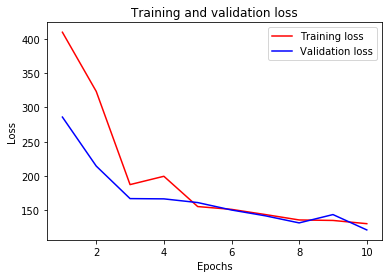

In [23]:
import matplotlib.pyplot as plt

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [24]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_test_pred = model_lstm.predict(X_test_series)
lstm_test_pred_tmp = model_lstm.predict(X_test_tmp)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, lstm_test_pred)))

Train rmse: 10.942414296701543
Test rmse: 10.963481293341088


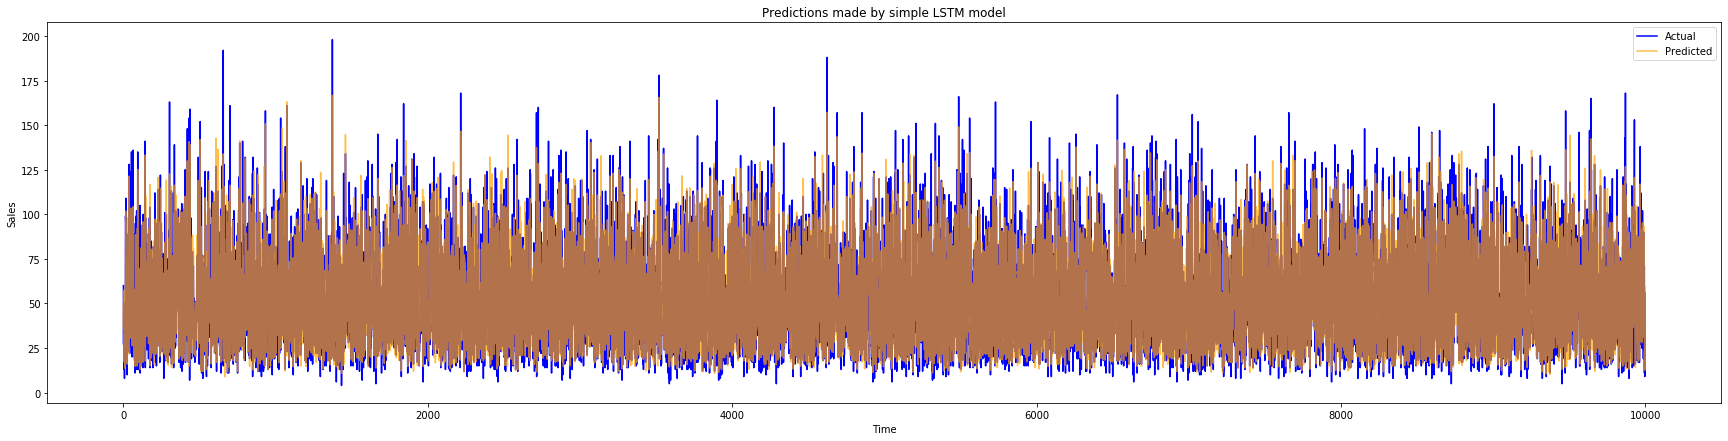

In [25]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(30,7))
    plt.plot(test, color='blue',label='Actual')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    
plot_predictions(Y_test_tmp, lstm_test_pred_tmp, "Predictions made by simple LSTM model")